<a href="https://colab.research.google.com/github/dlunaaa/Skin-Cancer-Project/blob/main/Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/dlunaaa/Skin-Cancer-Project.git

Cloning into 'Skin-Cancer-Project'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [ ]:
from google.colab import userdata
token = userdata.get('token')
repo_url = f"https://{token}@github.com/NHV4546/Skin-Cancer-Project.git"
%cd /content/Skin-Cancer-Project
!git config --global user.name "NHV4546"
!git config --global user.email "dinasamat0110@gmail.com"
!git remote set-url origin $repo_url

/content/Skin-Cancer-Project
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Everything up-to-date


In [ ]:
import kagglehub
# Downloading dataset HAM10000 from kagle
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")


100%|██████████| 5.20G/5.20G [00:56<00:00, 99.4MB/s]

Extracting files...


Before starting to work with data I have decided to merge into one folder, do it would be easier to work with it.

In [40]:

!mkdir -p /content/merged_images

!cp -r /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_part_1/* /content/merged_images/

!cp -r /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_part_2/* /content/merged_images/

!ls -la /content/merged_images | head -n 10


total 2725680
drwxr-xr-x 2 root root 331776 Mar 30 13:12 .
drwxr-xr-x 1 root root   4096 Mar 30 13:08 ..
-rw-r--r-- 1 root root 279172 Mar 30 13:11 ISIC_0024306.jpg
-rw-r--r-- 1 root root 274405 Mar 30 13:11 ISIC_0024307.jpg
-rw-r--r-- 1 root root 295747 Mar 30 13:11 ISIC_0024308.jpg
-rw-r--r-- 1 root root 278615 Mar 30 13:11 ISIC_0024309.jpg
-rw-r--r-- 1 root root 372386 Mar 30 13:11 ISIC_0024310.jpg
-rw-r--r-- 1 root root 273101 Mar 30 13:11 ISIC_0024311.jpg
-rw-r--r-- 1 root root 257771 Mar 30 13:11 ISIC_0024312.jpg


     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp


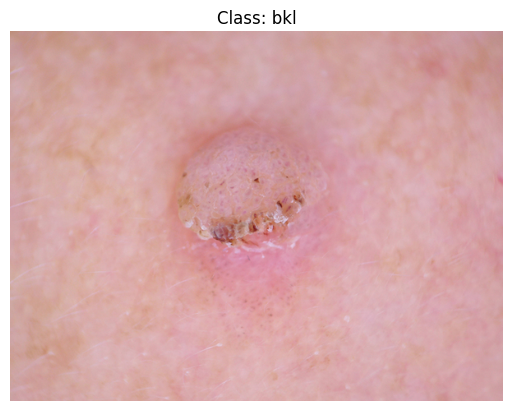

In [51]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

# Load metadata CSV file
df = pd.read_csv(os.path.join(path, 'HAM10000_metadata.csv'))

# Display the first row of the metadata
print(df.head(1))

# Get the image filename from the 7th row (index 6)
image_name = df.iloc[6]['image_id'] + '.jpg'

image_path = os.path.join('/content/merged_images', image_name)

# Load and display the image
img = Image.open(image_path)
plt.imshow(img)
plt.title(f"Class: {df.iloc[0]['dx']}")
plt.axis('off')
plt.show()


In [53]:
# For begining I am going to filter only 2 types of pigmented lesions - melanoma and nevus
df_filtered = df[df['dx'].isin(['mel', 'nv'])].copy()

# Drop index so we can have them from 0 continiously
df_filtered.reset_index(drop=True, inplace=True)
df_filtered['image_id'] = df_filtered['image_id'] + '.jpg'


print("Number of photos of each class: ")
print(df_filtered['dx'].value_counts())
print(df_filtered.head())



Number of photos of each class: 
dx
nv     6705
mel    1113
Name: count, dtype: int64
     lesion_id          image_id   dx    dx_type   age     sex  \
0  HAM_0001751  ISIC_0024698.jpg   nv  consensus  70.0    male   
1  HAM_0000559  ISIC_0024693.jpg   nv  follow_up  45.0  female   
2  HAM_0000871  ISIC_0025964.jpg  mel      histo  40.0  female   
3  HAM_0000871  ISIC_0030623.jpg  mel      histo  40.0  female   
4  HAM_0000040  ISIC_0027190.jpg  mel      histo  80.0    male   

      localization  
0             face  
1  upper extremity  
2            chest  
3            chest  
4  upper extremity  


To evaluate the quality and accuracy of our model we need to divide our dataset into two parts: training and testing

In [54]:
from sklearn.model_selection import train_test_split

# With stratify=df_binary['dx'] we make sure that portions of our classes are the same in both parts
train_df, test_df = train_test_split(df_filtered, test_size=0.2, random_state=42, stratify=df_filtered['dx'])

print("Training part size:", len(train_df))
print("Testing size part:", len(test_df))


Training part size: 6254
Testing size part: 1564


In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 224, 224
batch_size = 32

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join('/content/merged_images/'),
    x_col='image_id',
    y_col='dx',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='training'
)

# Validation generator
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join('/content/merged_images/'),
    x_col='image_id',
    y_col='dx',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='validation'
)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=os.path.join('/content/merged_images/'),
    x_col='image_id',
    y_col='dx',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 5004 validated image filenames belonging to 2 classes.
Found 1250 validated image filenames belonging to 2 classes.
Found 1564 validated image filenames belonging to 2 classes.
